In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import tensorflow as tf

from src.display import showarray
from src.mask import MaskGenerator
from src.datagen import DatasetFillGenerator

In [2]:
IMAGE_SIZE = (256, 256)
CHANNELS = 3
BATCH_SIZE = 32

MASK_GEN_PARAM = {
    "degree": "LIGHT",
    "min_width": 10,
    "max_width": 20,
}

mask_generator = MaskGenerator(*IMAGE_SIZE, CHANNELS, **MASK_GEN_PARAM)

In [4]:
def scale(x):
    return x / 255.0


ds_train, ds_valid = tf.keras.preprocessing.image_dataset_from_directory(
    directory="../data/all", label_mode=None, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    shuffle=True, seed=42, validation_split=0.1, subset="both",
)
ds_train = ds_train.map(scale)
ds_valid = ds_valid.map(scale)

Found 17507 files belonging to 1 classes.
Using 15757 files for training.
Using 1750 files for validation.


In [9]:
np.random.seed(42)
train_generator = DatasetFillGenerator(ds_train, IMAGE_SIZE, CHANNELS, mask_generator, scale_max=1.0)
valid_generator = DatasetFillGenerator(ds_valid, IMAGE_SIZE, CHANNELS, mask_generator, scale_max=1.0)

In [10]:
# dummy model for preview
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(*IMAGE_SIZE, 3)))
model.add(tf.keras.layers.Conv2D(32, 5, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(3 * IMAGE_SIZE[0] * IMAGE_SIZE[1], activation="sigmoid"))
model.add(tf.keras.layers.Reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 524288)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                16777248  
                                                                 
 dense_3 (Dense)             (None, 196608)            6488064   
                                                                 
 reshape_1 (Reshape)         (None, 256, 256, 3)       0         
                                                      

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
)

In [14]:
model.fit(valid_generator, epochs=10) # used valid_generator for faster training as this is just a preview

Epoch 1/10
55/55 [==============================] - 56s 1s/step - loss: 0.0608
Epoch 2/10
55/55 [==============================] - 56s 1s/step - loss: 0.0429
Epoch 3/10
55/55 [==============================] - 56s 1s/step - loss: 0.0416
Epoch 4/10
55/55 [==============================] - 56s 1s/step - loss: 0.0407
Epoch 5/10
55/55 [==============================] - 56s 1s/step - loss: 0.0404
Epoch 6/10
55/55 [==============================] - 57s 1s/step - loss: 0.0401
Epoch 7/10
55/55 [==============================] - 56s 1s/step - loss: 0.0398
Epoch 8/10
55/55 [==============================] - 56s 1s/step - loss: 0.0396
Epoch 9/10
55/55 [==============================] - 56s 1s/step - loss: 0.0394
Epoch 10/10
55/55 [==============================] - 56s 1s/step - loss: 0.0392


1/1 [==============================] - 0s 270ms/step


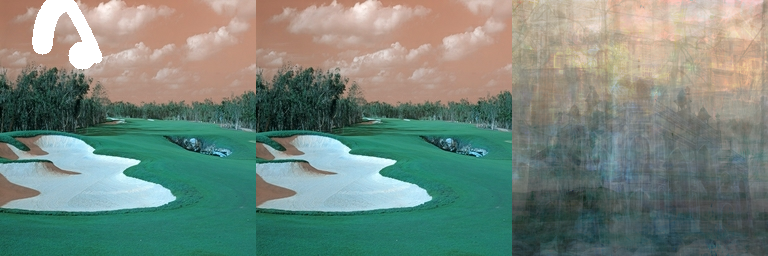

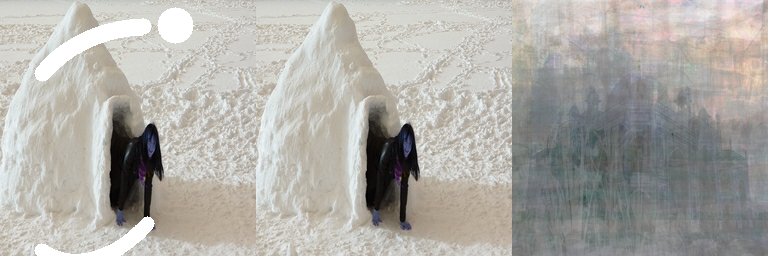

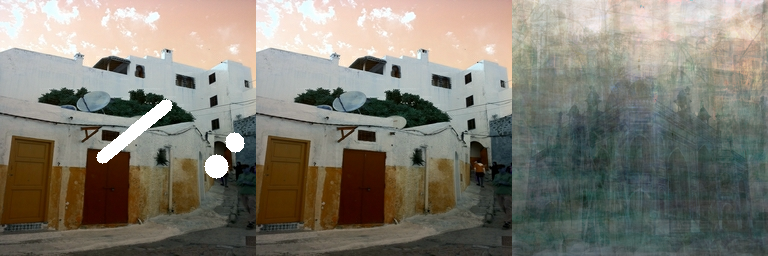

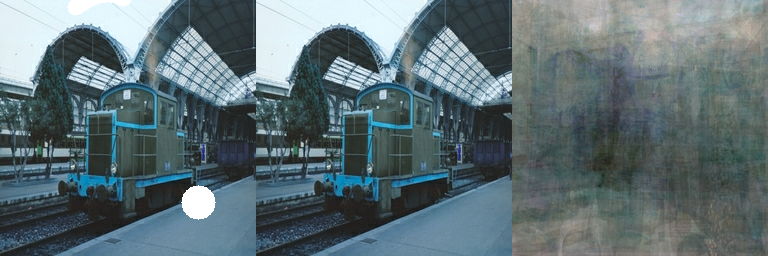

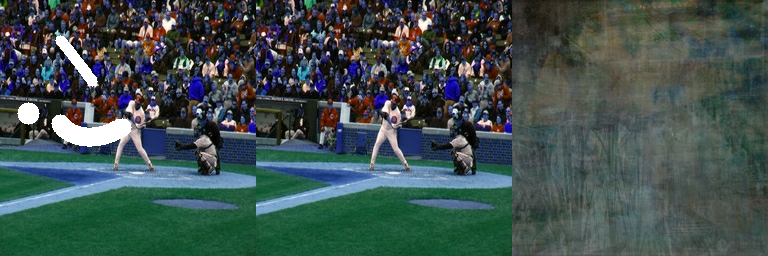

In [19]:
def recast_to_image(tensor: tf.Tensor) -> np.ndarray:
    return tf.cast(tensor * 255, tf.uint8).numpy()

batch_masks, batch_images = train_generator[0]
nn_filled = model.predict(batch_images)
for i in range(5):
    masked = recast_to_image(batch_masks[i])
    original_image = recast_to_image(batch_images[i])
    filled_image = recast_to_image(nn_filled[i])
    
    showarray(np.concatenate([masked, original_image, filled_image], axis=1))